# Astr 19 Final Project 2:

<i> Same as the the tutorial, but with the Hubble image instead

<div class = "alert alert-block alert-info">
    <i>First step is to import the necessary libraries:</i>
</div>  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sep
from matplotlib import rcParams
import math
%matplotlib inline

rcParams['figure.figsize'] = [8., 8.]

<div class = "alert alert-block alert-info">
    <i>Next up we read in the data file using astropy.io.fits:</i>
</div>  

In [65]:
rawdata = fits.open("/Users/walkermayer/downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = np.array(rawdata[0].data)

<div class = "alert alert-block alert-info">
    <i>Once we've read the data, we want to show the image. We'll do this using the imshow function in matplotlib.pyplot. </i>
</div>        

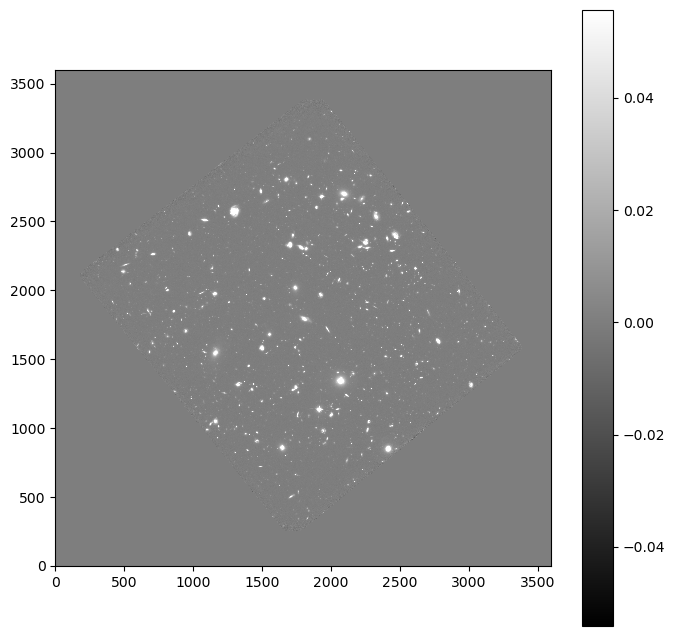

In [3]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower',)
plt.colorbar();
plt.savefig("rawimage.png")
plt.show()

<div class = "alert alert-block alert-info">
    <i>After we produce the image, we need to do some background subtraction to more easily detect sources. We'll do this using the background funtion in sep. </i>
</div> 

In [4]:
# Finding the background
data_sw = data.byteswap().newbyteorder()
bkg = sep.Background(data_sw)

In [5]:
bkg_mean = bkg.globalback
bkg_rms = bkg.globalrms

print(bkg_mean)
print(bkg_rms)

0.0
0.0005398219218477607


<div class = "alert alert-block alert-info">
    <i> Now we need to make the background into a 2-d array so we can plot the background. Once we do this we'll use imshow() to plot the background. </i> 
</div> 

In [6]:
bkg_image = bkg.back()

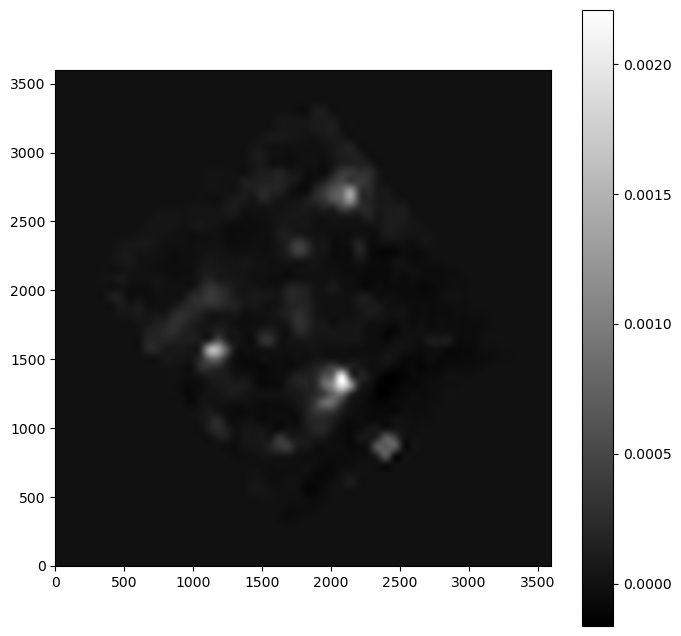

In [7]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("bkgimage.png")
plt.show()

<div class = "alert alert-block alert-info">
    <i> Now we'll do the same thing with the noise, converting it into a 2-d array so we can plot it. 
    Yet again, we'll use imshow() to plot the noise. </i> 
</div>

In [8]:
bkg_rms = bkg.rms()

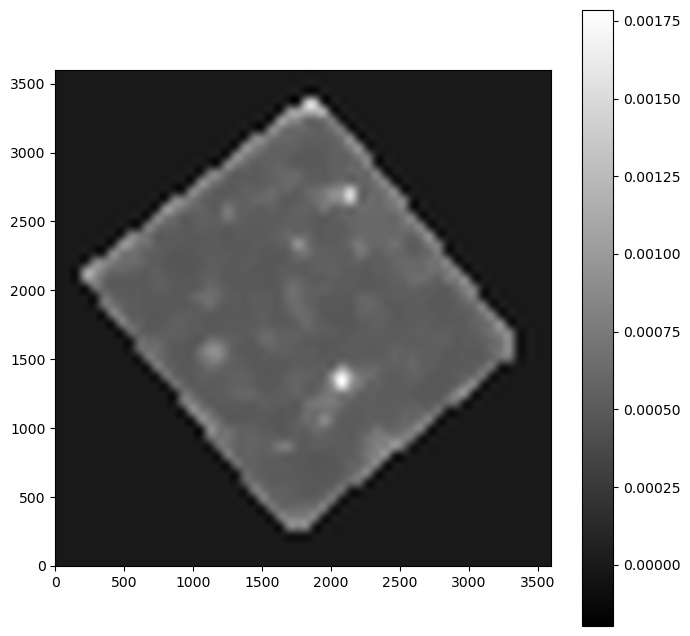

In [9]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("bkgnoise.png")
plt.show()

<div class = "alert alert-block alert-info">
    <i> The next step is to subtract the background. We do this to help with object detection, which we'll do using the sep.extract function. </i> 
</div>

In [10]:
data_sub = data - bkg

In [11]:
objects = sep.extract(data_sub, 15, err=bkg.globalrms)

<div class = "alert alert-block alert-info">
    <i> We can now see how many objects were detected, and also produce a plot where each detected object has a red circle showing where it is. </i> 
</div>

In [12]:
print(f'There were {len(objects)} objects detected in this image.')

There were 1158 objects detected in this image.


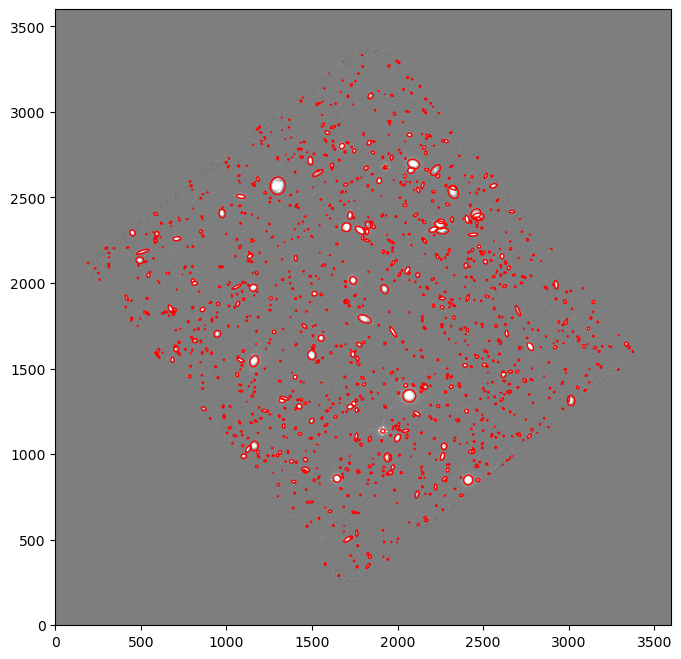

In [13]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("finalimage.png")

<div class = "alert alert-block alert-info">
    <i> Lastly, we can do some simple aperture photometry to print out the fluxes of each detected object. </i> 
</div>

In [14]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [15]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 1.153159 +/- 1.073856
object 1: flux = 0.553503 +/- 0.743983
object 2: flux = 1.125336 +/- 1.060822
object 3: flux = 0.874867 +/- 0.935348
object 4: flux = 0.289051 +/- 0.537642
object 5: flux = 0.693598 +/- 0.832830
object 6: flux = 0.214496 +/- 0.463146
object 7: flux = 0.497867 +/- 0.705602
object 8: flux = 0.748867 +/- 0.865376
object 9: flux = 1.255536 +/- 1.120511


<div class = "alert alert-block alert-info">
    <i> Now we can make a histogram of the detected fluxes. </i> 
</div>

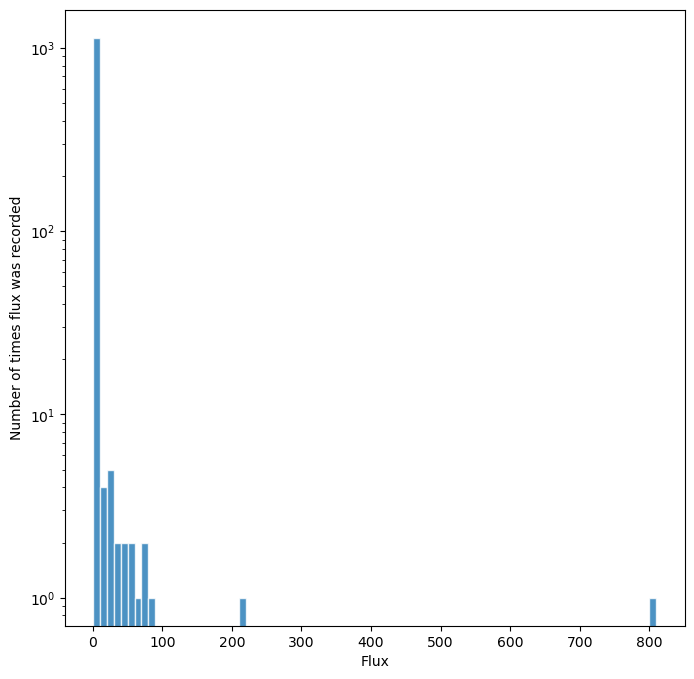

In [16]:
# First make the histogram bins
width = 10
histmin = np.min(flux)  
histmax = np.max(flux) + width  # making sure to add width to include the outlier on the plot

bins = np.arange(histmin,histmax,width)
plt.hist(flux, bins=bins, edgecolor = 'white', alpha = 0.8, log = True) # using a log scale for clarity
plt.xlabel('Flux')
plt.ylabel('Number of times flux was recorded')
plt.show()

<div class = "alert alert-block alert-info">
    <i> We can now print some info on the fluxes, and specifically the outlier. </i> 
</div>

In [17]:
print(f'The mean of the measured fluxes was {np.mean(flux):.6f} \n'
f'The median of the fluxes was {np.median(flux):.6f} \n'
f'The standard deviation of the measured fluxes was {np.std(flux):.6f} \n')

The mean of the measured fluxes was 2.486412 
The median of the fluxes was 0.466471 
The standard deviation of the measured fluxes was 25.078516 



In [79]:
value1 = (np.max(flux) - np.mean(flux)) / np.std(flux)
print(f'The outlier is {value1:.4f} '
f'standard deviations away from the mean.' )

The outlier is 31.9930 standard deviations away from the mean.


<div class = "alert alert-block alert-info">
    <i> Lastly, we can make some false color images of some other data. </i> 
</div>

In [68]:
rawf160w = fits.open("/Users/walkermayer/downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
f160w = np.array(rawf160w[0].data)
rawf125w = fits.open("/Users/walkermayer/downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
f125w = np.array(rawf125w[0].data)
rawf105w = fits.open("/Users/walkermayer/downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
f105w = np.array(rawf105w[0].data)

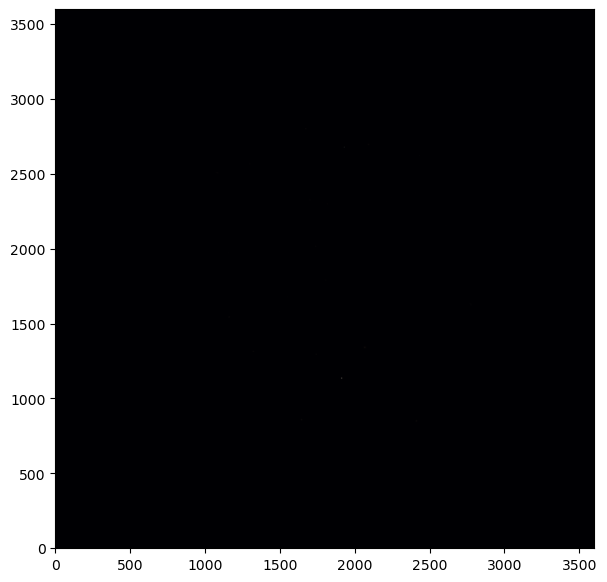

In [78]:
rgb_image = np.zeros((3600, 3600, 3))

rgb_image[:, :, 0] = (f160w - np.min(f160w)) / (np.max(f160w) - np.min(f160w))
rgb_image[:, :, 1] = (f125w - np.min(f125w)) / (np.max(f125w) - np.min(f125w))
rgb_image[:, :, 2] = (f105w - np.min(f105w)) / (np.max(f105w) - np.min(f105w))

f = plt.figure(figsize = (7,7))
plt.imshow(rgb_image, origin = 'lower')
plt.savefig('galaxyimage.png')
plt.show()

<div class = "alert alert-block alert-info">
    <i> Not sure why the image isn't working :( </i> 
</div>